 # Analysis of WhatsApp Messages using NLP

In [1]:
# importing useful libraries, that we might use
# you will need to run "jupyter nbextension install --py fileupload" before running this cell
!jupyter nbextension enable --py fileupload

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import wordcloud
import numpy as np
import pandas as pd
from IPython.display import display
from ipywidgets import *
import re
import requests
from PIL import Image
import io
import sys
import glob
import os
sns.set_style('whitegrid')

Enabling notebook extension fileupload/extension...
      - Validating: problems found:
        - require?  X fileupload/extension


## Data Load and Analysis

In [2]:
#Using the glob to import the 2 chat data and appending one under the other to get one Dataframe
# chat1 and chat2 contains our conversations in 2 different phone numbers. 
all_csv = glob.glob("personal_data/chat*.txt") #Giving globa pattern to look for in the directory

list_csv = []

for filename in all_csv:
    df = pd.read_csv(filename,header=None, sep='\t', error_bad_lines=False)
    list_csv.append(df)

msg = pd.concat(list_csv, axis=0, ignore_index=True)

b'Skipping line 19400: expected 1 fields, saw 3\nSkipping line 19401: expected 1 fields, saw 3\nSkipping line 28622: expected 1 fields, saw 2\n'
b'Skipping line 12204: expected 1 fields, saw 2\nSkipping line 12207: expected 1 fields, saw 2\n'


In [3]:
#Checking the shape of our data
for index, data in enumerate(list_csv):
    print(f'{data.shape}------------------>Chat {index+1}\n')
print(f'{msg.shape}------------------>Combined Chat')

msg.sample(10) #checking the head of the dataframe

(40616, 1)------------------>Chat 1

(13279, 1)------------------>Chat 2

(53895, 1)------------------>Combined Chat


,0
702,14.10.2019 16:21 - Cansu: Ground floor
53441,30.01.2021 00:20 - Rafi Sweden: You need to sh...
39709,09.09.2020 13:28 - Rafi: Yes and no
7370,06.01.2020 23:16 - Rafi: Also I love you
50539,29.12.2020 08:58 - Rafi Sweden: 🤣
23674,16.05.2020 00:22 - Rafi: But you are too
5321,06.12.2019 10:31 - Cansu: Why
46650,22.11.2020 20:38 - Rafi Sweden: 😎
22597,09.05.2020 14:05 - Cansu: 6 monts
18047,14.04.2020 16:25 - Rafi: Spoke to hilal and my...


In [4]:
msg.drop(axis=0, index=0, inplace=True) #Dropping the generic whatsapp message

msg.columns = ['Message'] #Renaming the one column we have

msg.head()

,Message
1,08.10.2019 10:11 - Rafi: Better
2,08.10.2019 10:11 - Rafi: How're you?
3,08.10.2019 10:54 - Cansu: Good
4,08.10.2019 10:54 - Cansu: What about you?
5,08.10.2019 10:58 - Rafi: Meh


In [5]:
sender_msg = msg['Message'].str.split('-').str[1]

msg['Date']=msg['Message'].str.split('-').str[0] 

msg['sender']=sender_msg.str.split(":").str[0]

msg['message']=sender_msg.str.split(":").str[1]

#msg['Time_of_day'] = msg['Date'].str.split(' ').str[-2]

msg['Time'] = msg['Date'].str.split(' ').str[-2]
#msg['Time'] = msg['Date'].str.split(',').str[1]

msg['Date'] = msg['Date'].str.split(' ').str[0]

msg.drop(axis=1, columns ='Message', inplace=True)

msg.head()

,Date,sender,message,Time
1,08.10.2019,Rafi,Better,10:11
2,08.10.2019,Rafi,How're you?,10:11
3,08.10.2019,Cansu,Good,10:54
4,08.10.2019,Cansu,What about you?,10:54
5,08.10.2019,Rafi,Meh,10:58


In [6]:
msg['message']
msg['message'].to_csv('personal_data/messages.csv', index=False)
#save messages as csv file 

In [7]:
print(msg['message'].value_counts().head()) #just checking the most frequently sent messages

 <Medya dahil edilmedi>    1924
 🤣                         1571
 🥰                         1265
 😅                         1030
 🤣🤣🤣                        571
Name: message, dtype: int64


In [8]:
# Since we don't have images in our dataset, "Medya dahil edilmedi" is an automatic error when picture is not available in dataset.
# "https" are available in the dataset since we shared web links. 
# Drop ' <Medya dahil edilmedi>' and https
msg[(msg.message != ' <Medya dahil edilmedi>') & (msg.message != ' https')]
print(msg['message'].value_counts().head()) # checking the most frequently sent messages again 

 <Medya dahil edilmedi>    1924
 🤣                         1571
 🥰                         1265
 😅                         1030
 🤣🤣🤣                        571
Name: message, dtype: int64


In [9]:
print(msg['sender'].value_counts().head()) #just checking the most frequently sent messages

 Cansu            27735
 Rafi             19023
 Rafi Sweden       6350
language/free/        9
a")                   3
Name: sender, dtype: int64


In [10]:
print(msg['sender'].value_counts())

 Cansu                                                                               27735
 Rafi                                                                                19023
 Rafi Sweden                                                                          6350
language/free/                                                                           9
a")                                                                                      3
                                                                                     ...  
 Get in touch with the faculty member you want as your independent study advisor.        1
g4 pairs                                                                                 1
 20                                                                                      1
 gene D                                                                                  1
development/free/                                                                        1

In [11]:
# Make Rafi Sweden and Rafi as "Rafsan"
msg.sender.replace(to_replace = [' Rafi',' Rafi Sweden'], value=[' Rafsan',' Rafsan'], inplace=True)
msg['sender'].value_counts().head()

 Cansu            27735
 Rafsan           25373
language/free/        9
a")                   3
> plural              2
Name: sender, dtype: int64

In [12]:
# Drop others different than Cansu and Rafsan
Rafsan_msg=msg[(msg.sender == ' Rafsan')]
Cansu_msg=msg[(msg.sender == ' Cansu')]
frames = [Rafsan_msg, Cansu_msg]
result = pd.concat(frames)
print(result)

             Date   sender                                       message  \
1      08.10.2019   Rafsan                                        Better   
2      08.10.2019   Rafsan                                   How're you?   
5      08.10.2019   Rafsan                                           Meh   
6      08.10.2019   Rafsan                      You're busy today right?   
9      08.10.2019   Rafsan                                     Just work   
...           ...      ...                                           ...   
53886  05.02.2021    Cansu   I did not know the churn analysis was there   
53887  05.02.2021    Cansu                        and I got one citation   
53888  05.02.2021    Cansu                                           🤣🤣🤣   
53892  05.02.2021    Cansu                                            🤣🤣   
53893  06.02.2021    Cansu                                       Potatis   

        Time  
1      10:11  
2      10:11  
5      10:58  
6      10:59  
9      11:15

In [13]:
result['sender'].value_counts().head()
#now we just have Rafsan and Cansu.

 Cansu     27735
 Rafsan    25373
Name: sender, dtype: int64

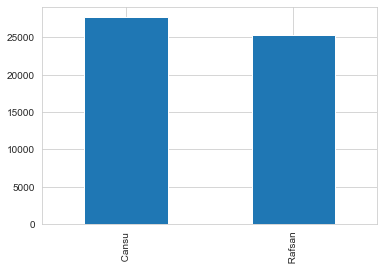

In [14]:
result['sender'].value_counts().plot(kind='bar');

## LETS DO SOME ANALYSIS ON RAFSAN'S MESSAGES!

In [15]:
Rafsan_msg.head()

,Date,sender,message,Time
1,08.10.2019,Rafsan,Better,10:11
2,08.10.2019,Rafsan,How're you?,10:11
5,08.10.2019,Rafsan,Meh,10:58
6,08.10.2019,Rafsan,You're busy today right?,10:59
9,08.10.2019,Rafsan,Just work,11:15


In [16]:
Rafsan_msg.describe()

,Date,sender,message,Time
count,25373,25373,25373,25373
unique,488,1,13146,1263
top,15.04.2020,Rafsan,🤣,00:19
freq,234,25373,1280,86


In [17]:
Rafsan_msg.Time = pd.to_datetime(Rafsan_msg.Time)
#Convert Rafsan_msg.Time to datetime format.

C:\anaconda\lib\site-packages\pandas\core\generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [21]:
Rafsan_msg.message.value_counts().head()# the most frequent messages of him.

 🤣                         1280
 🥰                          739
 😅                          713
 <Medya dahil edilmedi>     479
 🤣🤣🤣                        330
Name: message, dtype: int64

In [93]:
#chart function takes messaging times as hours and shows them on histogram. 
def chart(occurance_list):
    hour_list = [t.hour for t in occurance_list]
    #print (hour_list)
    numbers=[x for x in range(0,24)]
    labels=map(lambda x: str(x), numbers)
    plt.xticks(numbers, labels)
    plt.xlim(0,24)
    plt.hist(hour_list)
    plt.xlabel("Hours")
    plt.ylabel("Counts")
    plt.show()
    
def chart2(occurance_list):
    hour_list = [t.hour for t in occurance_list]
    #print (hour_list)
    numbers=[x for x in range(0,24)]
    labels=map(lambda x: str(x), numbers)
    plt.xticks(numbers, labels)
    plt.xlim(0,24)
    plt.xlabel("Hours")
    plt.ylabel("Counts")
    #sns.distplot(hour_list, bins = 10, kde = True, hist=False)
    sns.kdeplot(hour_list, shade = True); 

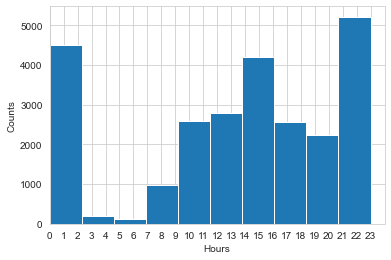

In [94]:
# Rafsan's messaging times were given below. 
rafi_hist=chart(Rafsan_msg.Time)

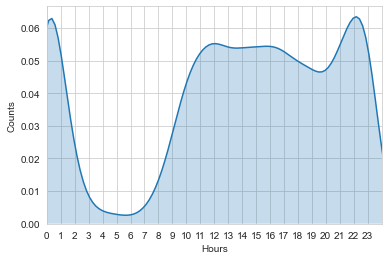

In [96]:
chart2(Rafsan_msg.Time)# show the distribution

C:\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


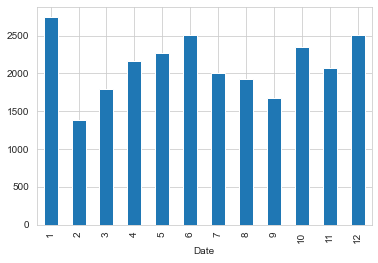

In [99]:
# Rafsan' messaging dates given below
Rafsan_msg["Date"] = Rafsan_msg["Date"].astype("datetime64")
Rafsan_msg["Date"].groupby(Rafsan_msg["Date"].dt.month).count().plot(kind="bar");

## LETS DO SOME ANALYSIS ON CANSU'S MESSAGES!

In [100]:
Cansu_msg.head()

,Date,sender,message,Time
3,2019-08-10,Cansu,Good,2021-02-14 10:54:00
4,2019-08-10,Cansu,What about you?,2021-02-14 10:54:00
7,2019-08-10,Cansu,Yup,2021-02-14 11:14:00
8,2019-08-10,Cansu,Wanna tell me?,2021-02-14 11:14:00
12,2019-08-10,Cansu,Kuzum i am free,2021-02-14 12:07:00


In [105]:
Cansu_msg.describe()

C:\anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.
C:\anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,Date,sender,message,Time
count,27735,27735,27735,27735
unique,488,1,15250,1307
top,2020-04-15 00:00:00,Cansu,<Medya dahil edilmedi>,2021-02-14 00:21:00
freq,214,27735,1445,82
first,2019-01-11 00:00:00,NaN,NaN,2021-02-14 00:00:00
last,2021-12-01 00:00:00,NaN,NaN,2021-02-14 23:59:00


In [103]:
Cansu_msg.Time = pd.to_datetime(Cansu_msg.Time)
#Convert Rafsan_msg.Time to datetime format.

In [107]:
Cansu_msg.message.value_counts().head()# the most frequent messages of her.

 <Medya dahil edilmedi>    1445
 🥰                          526
 https                      355
 😅                          317
 🤣                          291
Name: message, dtype: int64

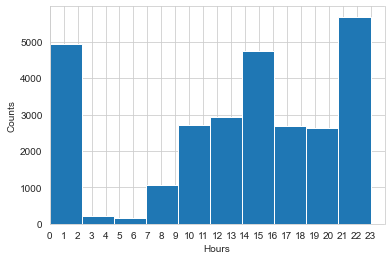

In [106]:
cansu_hist=chart(Cansu_msg.Time)

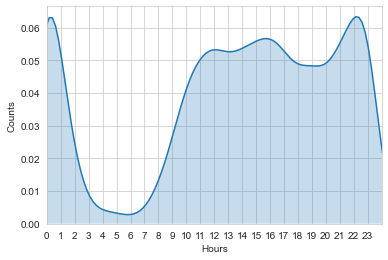

In [108]:
chart2(Cansu_msg.Time)# show the distribution

C:\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


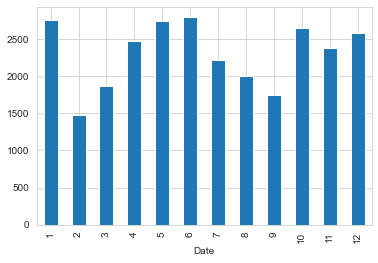

In [109]:
# Cansu' messaging dates given below
Cansu_msg["Date"] = Cansu_msg["Date"].astype("datetime64")
Cansu_msg["Date"].groupby(Cansu_msg["Date"].dt.month).count().plot(kind="bar");

# Comparison Charts

## Visualization of the amount of messages based on texting hours for each person

In [110]:
#Message texting comparisons based on texting hours.
def hours_comperison(list_c, list_r):
    hour_list_c = [t.hour for t in list_c]
    hour_list_r = [t.hour for t in list_r]
    numbers=[x for x in range(0,24)]
    labels=map(lambda x: str(x), numbers)
    plt.xticks(numbers, labels)
    plt.xlim(0,24)
    plt.hist(hour_list_c, alpha=0.5, label='Cansu')
    plt.hist(hour_list_r, alpha=0.5, label='Rafsan')
    plt.xlabel("Hours")
    plt.ylabel("Counts")
    plt.legend(loc='best')
    plt.show()

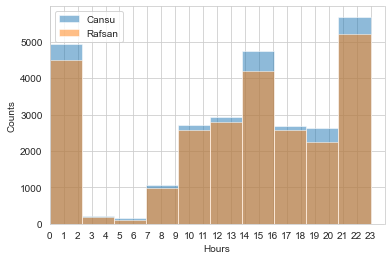

In [111]:
hours_comperison(Cansu_msg.Time, Rafsan_msg.Time)

## Visualization of the amount of messages each month for each person

In [112]:
cans_dates=Cansu_msg["Date"].groupby(Cansu_msg["Date"].dt.month).count()
rafi_dates=Rafsan_msg["Date"].groupby(Rafsan_msg["Date"].dt.month).count()
cans_dates=pd.DataFrame(cans_dates)
rafi_dates=pd.DataFrame(rafi_dates)
cans_dates_list=cans_dates.values.tolist()
rafi_dates_list=rafi_dates.values.tolist()
print(rafi_dates_list)

[[2739], [1382], [1795], [2161], [2269], [2503], [2003], [1931], [1669], [2353], [2067], [2501]]


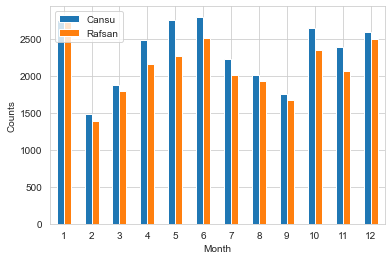

In [113]:
index = ['1', '2','3','4','5','6','7','8','9','10','11','12']
c_int_list=[2757, 1483, 1871, 2482, 2747, 2796, 2225, 2012, 1747, 2647, 2383, 2585]
r_int_list=[2739, 1382, 1795, 2161, 2269, 2503, 2003, 1931, 1669, 2353, 2067, 2501]
df = pd.DataFrame({'Cansu': c_int_list,
                   'Rafsan': r_int_list}, index=index)
ax = df.plot.bar(rot=0)
plt.xlabel("Month")
plt.ylabel("Counts")
plt.legend(loc='best');

## Display wordcloud image 

In [33]:
os.listdir('personal_data/') #Checking our data

['chat 1.txt', 'chat 2.txt', 'messages.csv']

In [34]:
#upload messages.csv
from ipywidgets import FileUpload
upload = FileUpload()
upload

FileUpload(value={}, description='Upload')

In [35]:
fontpath = None
def calculate_frequencies(chat_history, mask=None):
    #Decoding the data from the Upload widget
    chat_history = chat_history[0].decode('utf-8')
    
    # Here is a list of punctuations and uninteresting words you can use to process your text
    punctuations = '''1-9!()-[]{};:'"\,<>./?@#$%^&*_~'''
    uninteresting_words = ["the", "a", "to", "in","if", "for","is", "it","im", "of", "and", "or", "an", "as", "i", "me", "my", \
    "we", "our", "ours", "you", "your", "yours", "he", "she","dont","https", "him", "his", "her", "hers", "its", "they", "them", \
    "their", "what", "which", "who", "whom", "this", "that", "am", "are", "was", "were", "be", "been", "being", \
    "have", "has", "had", "do", "does", "did", "but", "at", "by", "with", "from", "here", "when", "where", "how", \
    "all", "any", "both", "each", "on", "few", "more", "some", "such", "no", "nor", "too", "very", "can", "will", "just",\
    'pm', 'am', 'media', 'not', 'found', 'oh', 'so', 'medya','dahil',"sildiniz",'edilmedi','rafi','cansu','2020','then','thats','sesli','much','mesajı']
    
    uninteresting_words2=uninteresting_words

    # LEARNER CODE START HERE
    word_dict = {}
    new_s = [i.lower() for i in chat_history if i.isalnum() or i.isalpha() or i.isspace()]
    word = ''.join(new_s)
    def remove_punctuation(s):
        return re.sub(r'[^\w 0-9]|_', '', s)
    word = remove_punctuation(word).split()
    for i in word:
        if i in uninteresting_words2:
            pass    
        else:
            word_dict[i] = word_dict.get(i, 0) + 1
    
    #wordcloud    
    cloud = wordcloud.WordCloud(font_path=fontpath,scale=9, max_words=200, mask=mask, 
                                stopwords=wordcloud.STOPWORDS, background_color='white', font_step=1,
                                colormap='inferno', min_word_length=4)
    cloud.generate_from_frequencies(word_dict)
    return cloud.to_array()

In [36]:
# Display your wordcloud image

myimage = calculate_frequencies(upload.data)
plt.figure(figsize=(10,6), dpi=1000)
plt.imshow(myimage, interpolation = 'nearest')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()